In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import math
import tqdm
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from cupy.cuda import Device
from text_vae.cvae import RnnVae
from text_vae.metrics import Evaluator
from sklearn.datasets.lfw import Bunch
from torch.nn.utils import clip_grad_norm_
from collections import UserList, defaultdict
from torch.optim.lr_scheduler import _LRScheduler
from text_vae.corpus import SSTCorpus, WikiText2Corpus, IMDBCorpus
from text_vae.misc import KLAnnealer, CosineAnnealingLRWithRestart, Logger, LogPlotter, reject_outliers, SamplePlotter

In [4]:
path = Bunch(
    save='vae.pt'
)

In [5]:
!nvidia-smi

Mon Jun  4 22:40:13 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 49%   66C    P0    67W / 250W |     19MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 85%   91C    P2    95W / 250W |  10608MiB / 11172MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
args = Bunch(
    # Model
    model=Bunch(
        q=Bunch(
            cell='gru',
            d_h=64,
            n_layers=2,
            r_dropout=0.0,  # should be around 0 to help encoder train more easily
            s_dropout=0.0  # same as `r_dropout`
        ),
        g=Bunch(
            cell='gru',
            n_layers=2,
            r_dropout=0.3,
            s_dropout=0.0
        ),
        d=Bunch(
            n_filters=3
        ),
        d_z=64,
        d_c=2,
        n_len=30 + 2,  # + <bos> and <eos>
        n_vocab=10000,  # 'up to' value
        d_emb=50,
        p_word_dropout=0.3,
        freeze_embeddings=False,
        attention=True
    ),
    # Train
    train=Bunch(
        n_batch=64,
        n_iter_per_epoch=5000,  # n_epoch will be calcaulated based on lr setting
        grad_clipping=5,
        kl=Bunch(
            i_start=1,
            w_start=1e-3,
            w_max=0.4
        ),
        lr=Bunch(
            value=1e-2,
            scheduler=Bunch(
                n_period=10,
                n_r=1,  # number of restarts in SGDR
                n_mult=2,
                lr_min=1e-3
            )
        )
    ),
    # Val
    val=Bunch(
        sample_params=Bunch(
            n_beam=1,
            coverage_penalty=False
        ),
        n_hypot=100,
        n_ref=500
    ),
    # Env
    device_code=0
)

In [7]:
device = torch.device(
    f'cuda:{args.device_code}' 
    if args.device_code >= 0 and torch.cuda.is_available()
    else 'cpu'
)
Device(device.index).use()  # cupy for SRU to work
device

device(type='cuda', index=0)

In [8]:
# Sents with targets
%time corpus = SSTCorpus(**args.model, n_batch=args.train.n_batch, device=device)
# LM
# %time corpus = WikiText2Corpus(**args.model, n_batch=args.train.n_batch, device=device)
# Sents with targets, `val` same as `test` (so we overfit a bit), `unlabeled` xs same as `labeled` xs
# %time corpus = IMDBCorpus(**args.model, n_batch=args.train.n_batch, device=device)
corpus.size('train'), corpus.size('val'), corpus.size('test'), len(corpus.vocab('x'))

CPU times: user 2.84 s, sys: 88.1 ms, total: 2.93 s
Wall time: 2.93 s


(5983, 769, 1605, 10000)

In [9]:
model = RnnVae(
    **args.model, 
    x_vocab=corpus.vocab('x')
).to(device)
model

RnnVae(
  (x_emb): Embedding(10000, 50, padding_idx=1)
  (encoder_rnn): GRU(50, 64, num_layers=2)
  (q_mu): Linear(in_features=64, out_features=64, bias=True)
  (q_logvar): Linear(in_features=64, out_features=64, bias=True)
  (decoder_rnn): GRU(116, 66, num_layers=2, dropout=0.3)
  (decoder_a): SelfAttention(
    (linear_in): Linear(in_features=66, out_features=66, bias=False)
    (linear_out): Linear(in_features=132, out_features=66, bias=False)
    (activation): SELU()
  )
  (decoder_fc): Linear(in_features=66, out_features=10000, bias=True)
  (disc_cnn): CNNEncoder(
    (_activation): ReLU()
    (conv_layer_0): Conv1d(2, 3, kernel_size=(2,), stride=(1,))
    (conv_layer_1): Conv1d(2, 3, kernel_size=(3,), stride=(1,))
    (conv_layer_2): Conv1d(2, 3, kernel_size=(4,), stride=(1,))
    (conv_layer_3): Conv1d(2, 3, kernel_size=(5,), stride=(1,))
  )
  (encoder): ModuleList(
    (0): GRU(50, 64, num_layers=2)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in

In [10]:
sampler = lambda s: corpus.reverse(model.sample_sentence(s, **args.val.sample_params)[2])
evaluator = Evaluator(corpus, args.val.n_ref, sample_params=args.val.sample_params)
sampler(1)[0]  # sanity check

'recording preciousness own shatner surprises justifies mouth team populates overmanipulative obscenity fluid cameos concoction quentin carol beneath photography dystopian trapped boxes trademark fatale guaranteed descends egoyan creek sumptuous 101 third stretched'

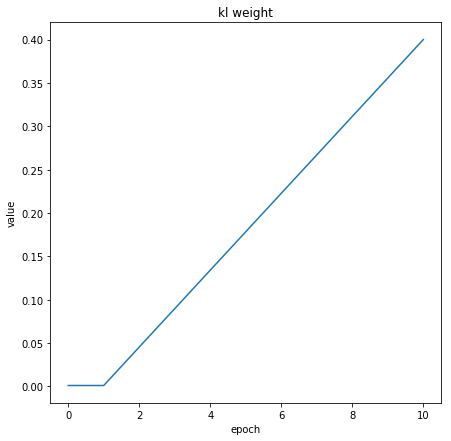

In [11]:
n_epoch = sum(args.train.lr.scheduler.n_period * (args.train.lr.scheduler.n_mult ** i)
              for i in range(args.train.lr.scheduler.n_r))
kl_annealer = KLAnnealer(**args.train.kl, n_epoch=n_epoch)
xs = np.linspace(0, n_epoch, num=n_epoch + 1)
ts = np.array([kl_annealer(i) for i in xs])
plt.figure(figsize=(7, 7))
plt.ylabel('value')
plt.xlabel('epoch')
plt.title('kl weight')
plt.plot(xs, ts);

In [12]:
get_params = lambda: (p for p in model.vae.parameters() if p.requires_grad)
trainer = optim.Adam(get_params(), lr=args.train.lr.value)
lr_scheduler = CosineAnnealingLRWithRestart(trainer, **args.train.lr.scheduler)

In [13]:
model.train()
batcher = corpus.batcher('train', 'unlabeled')
T = tqdm.tqdm_notebook(range(n_epoch))
n_iter = args.train.n_iter_per_epoch
elog, ilog = Logger(), Logger()

for epoch in T:
    # Epoch start
    kl_weight = kl_annealer(epoch)
    
    # Iters
    for i in range(n_iter):
        # Forward
        x = next(batcher)
        kl_loss, recon_loss = model(x, use_c_prior=True)
        loss = kl_weight * kl_loss + recon_loss
        
        # Backward
        trainer.zero_grad()
        loss.backward()
        clip_grad_norm_(get_params(), args.train.grad_clipping)
        trainer.step()
        
        # Log
        lr = trainer.param_groups[0]['lr']
        ilog.append({
            'epoch': epoch,
            'kl_loss': kl_loss.item(),
            'recon_loss': recon_loss.item(),
            'loss': loss.item(),
            'kl_weight': kl_weight,
            'lr': lr
        })
        
        # Update T
        kl_loss_value = np.mean(reject_outliers(ilog['kl_loss'][-args.train.n_iter_per_epoch:]))
        recon_loss_value = np.mean(reject_outliers(ilog['recon_loss'][-args.train.n_iter_per_epoch:]))
        loss_value = np.mean(reject_outliers(ilog['loss'][-args.train.n_iter_per_epoch:]))
        postfix_strs = []
        postfix_strs.append(f'i={i}/{n_iter}')
        postfix_strs.append(f'kl_loss={kl_loss_value:.5f}')
        postfix_strs.append(f'recon_loss={recon_loss_value:.5f}')
        postfix_strs.append(f'loss={loss_value:.5f}')
        postfix_strs.append(f'klw={kl_weight:.3f} lr={lr:.5f}')
        T.set_postfix_str(' '.join(postfix_strs))
        T.refresh()
    
    # Log
    sent = sampler(1)[0]
    bleu = evaluator.bleu(model, args.val.n_hypot, 'val')
    self_bleu = evaluator.self_bleu(model, args.val.n_hypot)
    ppl = evaluator.perplexity(model, 'val')
    elog.append({
        **{k: v for k, v in ilog[-1].items() if 'loss' not in k},
        'kl_loss': kl_loss_value,
        'recon_loss': recon_loss_value,
        'loss': loss_value,
        'sent': sent,
        'bleu': bleu,
        'self_bleu': self_bleu,
        'ppl': ppl
    })
    
    # Print result
    bleu_5, self_bleu_5 = bleu['5-gram'], self_bleu['5-gram']
    print(f"[epoch={epoch}, bleu_5={bleu_5:.3f} self_bleu_5={self_bleu_5:.3f} ppl={ppl:.3f}]: '{sent}'")
    
    # Epoch end
    lr_scheduler.step()

RuntimeError: rnn: hx is not contiguous

In [ ]:
plotter = LogPlotter(elog)
plotter.grid([
    'kl_loss', 'recon_loss',
    'loss', 'lr',
    'bleu', 'self_bleu',
    'epoch', 'ppl'
])

In [ ]:
splotter = SamplePlotter(corpus, model, sample_params=args.val.sample_params)
splotter.plot_one()

In [ ]:
%time evaluator.bleu(model, args.val.n_hypot, 'train')

In [ ]:
%time evaluator.bleu(model, args.val.n_hypot, 'test')

In [ ]:
%time evaluator.self_bleu(split='test')

In [ ]:
evaluator.self_bleu(model, args.val.n_hypot)

In [ ]:
torch.save((args, model), path.save)

In [ ]:
!du -sh {path.save}